<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predvidjanje vrednosti Bitcoina pomocu RNN**

**Korisceni atributi:** Open, High, Low, Close

**Filtrirani podaci:** od 28.03.2021.

## **Ucitavanje biblioteka**

In [681]:
# Ucitavanje biblioteka

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
#%run preprocessing.ipynb

## **Ucitavanje skupa podataka i pretprocesiranje**

In [682]:
#data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [683]:
##### DELETE

file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

# Ucitavanje skupa podataka
data = pd.read_csv(file_name)

# Dimenzije DataFrame-a
print('\n\nDimenzije skupa podataka pre sredjivanja:\n', data.shape)

# Ciscenje podataka od NaN vrednosti
data = data.dropna()

# Kreiranje datuma
data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)


# Filtriranje podataka
data = data.loc[data['Date'] > pd.to_datetime('2021-03-28')]

# Dimenzije DataFrame-a
print('\n\nDimenzije skupa podataka nakon sredjivanja:\n', data.shape)




Dimenzije skupa podataka pre sredjivanja:
 (4857377, 8)


Dimenzije skupa podataka nakon sredjivanja:
 (2872, 9)


### **Podela skupa podataka**

In [684]:
###### DELETE

def data_split(data, test_size = 0):

  if test_size <= 0:
    print('Vrednost parametra test_size mora biti strogo veca od 0.\n')
    return
  else: # test_size > 0
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  
  return train, test

In [685]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2)


# Podela train skupa podataka na train i validacioni skup

train, validation = data_split(train, test_size = 0.2)

In [686]:
# Dimenzije train, validation i test skupa

train.shape, validation.shape, test.shape

((1839, 9), (459, 9), (574, 9))

### **Vizualizacija validacionog skupa i train skupa**

In [687]:
##### DELETE

def plot_train_and_validation_data(train, validation):
  plt.title('Podaci za trening i validaciju')
  plt.xlabel('vreme')
  plt.ylabel('vrednost bitkoina')
  plt.plot(train, c = 'lime')
  plt.plot(validation, c = 'orchid')
  plt.show()

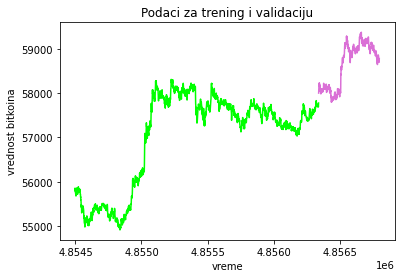

In [688]:
plot_train_and_validation_data(train = train['Close'], validation = validation['Close'])

### **Filtriranje trening, validacionog i test skupa**

In [689]:
# Izbacivanje nepotrebnih kolona (atributa) iz trening skupa

train_ = train.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head(), train_.shape

(             Open      High       Low     Close
 4854496  55790.28  55822.98  55777.98  55804.36
 4854497  55822.98  55857.28  55822.98  55857.28
 4854498  55822.98  55829.04  55766.15  55779.04
 4854500  55766.15  55768.63  55766.15  55768.63
 4854501  55770.46  55778.48  55736.83  55742.20, (1839, 4))

In [690]:
# Izbacivanje nepotrebnih kolona (atributa) iz validacionog skupa

validation_ = validation.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
validation_.head(), validation_.shape

(             Open      High       Low     Close
 4856341  57798.86  58000.00  57796.80  58000.00
 4856342  57993.11  58075.40  57970.05  58060.96
 4856343  58059.31  58147.08  58052.67  58103.06
 4856344  58103.06  58252.64  58095.24  58207.57
 4856345  58221.20  58221.20  58118.48  58159.93, (459, 4))

In [691]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
test_.head(), test_.shape

(             Open      High       Low     Close
 4856801  58799.01  58799.01  58730.34  58747.90
 4856802  58751.13  58825.89  58736.68  58825.89
 4856803  58814.40  58849.95  58808.56  58828.09
 4856804  58830.57  58849.80  58815.39  58835.62
 4856805  58849.61  58900.00  58849.61  58900.00, (574, 4))

In [692]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

train.shape, train_.shape

((1839, 9), (1839, 4))

In [693]:
# inverse = scaler.inverse_transform(normalized)

**Odredjivanje ciljne promenljive na train skupu**

In [694]:
##### DELETE

def determine_x_and_y(dataset):
  X = []
  y = []

  df = pd.DataFrame()

  for i in range(60, dataset.shape[0]):
    X.append(dataset[i-60:i])
    y.append(dataset[i,0])
  
  return X, y

In [695]:
# Odredjivanje ciljne promenljive na train skupu

X_train, y_train = determine_x_and_y(dataset = train_.to_numpy())


# Odredjivanje ciljne promenljive na validacionom skupu

X_validation, y_validation = determine_x_and_y(dataset = validation_.to_numpy())


# Odredjivanje ciljne promenljive na test skupu

X_test, y_test = determine_x_and_y(dataset = test_.to_numpy())

In [696]:
type(X_train)

list

In [697]:
X_train_df = pd.DataFrame(np.concatenate(X_train))
X_train_df

,0,1,2,3
0,55790.28,55822.98,55777.98,55804.36
1,55822.98,55857.28,55822.98,55857.28
2,55822.98,55829.04,55766.15,55779.04
3,55766.15,55768.63,55766.15,55768.63
4,55770.46,55778.48,55736.83,55742.20
...,...,...,...,...
106735,57706.41,57714.26,57696.51,57712.15
106736,57693.10,57703.07,57686.59,57695.65
106737,57681.79,57724.38,57681.79,57692.12
106738,57694.14,57709.17,57694.14,57709.17


In [698]:
X_validation_df = pd.DataFrame(np.concatenate(X_validation))
X_validation_df

,0,1,2,3
0,57798.86,58000.00,57796.80,58000.00
1,57993.11,58075.40,57970.05,58060.96
2,58059.31,58147.08,58052.67,58103.06
3,58103.06,58252.64,58095.24,58207.57
4,58221.20,58221.20,58118.48,58159.93
...,...,...,...,...
23935,58846.95,58850.77,58784.20,58790.24
23936,58808.81,58810.29,58700.00,58736.74
23937,58728.76,58786.71,58688.63,58779.95
23938,58784.11,58784.11,58694.74,58694.74


In [699]:
X_test_df = pd.DataFrame(np.concatenate(X_test))
X_test_df

,0,1,2,3
0,58799.01,58799.01,58730.34,58747.90
1,58751.13,58825.89,58736.68,58825.89
2,58814.40,58849.95,58808.56,58828.09
3,58830.57,58849.80,58815.39,58835.62
4,58849.61,58900.00,58849.61,58900.00
...,...,...,...,...
30835,58742.18,58742.18,58714.31,58714.31
30836,58714.31,58714.31,58686.00,58686.00
30837,58683.97,58693.43,58683.97,58685.81
30838,58693.43,58723.84,58693.43,58723.84


###**Skaliranje**

In [700]:
scaler0 = MinMaxScaler(feature_range=(0, 1))
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))

X_train_df[0] = scaler0.fit_transform(X_train_df[0].to_numpy().reshape(-1,1))
X_train_df[1] = scaler1.fit_transform(X_train_df[1].to_numpy().reshape(-1,1))
X_train_df[2] = scaler2.fit_transform(X_train_df[2].to_numpy().reshape(-1,1))
X_train_df[3] = scaler3.fit_transform(X_train_df[3].to_numpy().reshape(-1,1))

X_validation_df[0] = scaler0.transform(X_validation_df[0].to_numpy().reshape(-1,1))
X_validation_df[1] = scaler1.transform(X_validation_df[1].to_numpy().reshape(-1,1))
X_validation_df[2] = scaler2.transform(X_validation_df[2].to_numpy().reshape(-1,1))
X_validation_df[3] = scaler3.transform(X_validation_df[3].to_numpy().reshape(-1,1))

X_test_df[0] = scaler0.transform(X_test_df[0].to_numpy().reshape(-1,1))
X_test_df[1] = scaler1.transform(X_test_df[1].to_numpy().reshape(-1,1))
X_test_df[2] = scaler2.transform(X_test_df[2].to_numpy().reshape(-1,1))
X_test_df[3] = scaler3.transform(X_test_df[3].to_numpy().reshape(-1,1))

In [701]:
X_train_df

,0,1,2,3
0,0.257199,0.253943,0.261410,0.261923
1,0.266861,0.263863,0.274694,0.277515
2,0.266861,0.255696,0.257918,0.254462
3,0.250069,0.238225,0.257918,0.251395
4,0.251343,0.241074,0.249263,0.243608
...,...,...,...,...
106735,0.823368,0.800907,0.827744,0.824039
106736,0.819435,0.797671,0.824816,0.819178
106737,0.816093,0.803834,0.823399,0.818138
106738,0.819742,0.799435,0.827044,0.823161


In [702]:
X_validation_df

,0,1,2,3
0,0.850685,0.883544,0.857349,0.908852
1,0.908081,0.905350,0.908491,0.926814
2,0.927641,0.926080,0.932879,0.939218
3,0.940568,0.956608,0.945446,0.970011
4,0.975476,0.947515,0.952306,0.955974
...,...,...,...,...
23935,1.160369,1.129589,1.148821,1.141691
23936,1.149100,1.117882,1.123966,1.125927
23937,1.125447,1.111063,1.120609,1.138659
23938,1.141801,1.110311,1.122413,1.113552


In [703]:
X_test_df

,0,1,2,3
0,1.146204,1.114620,1.132922,1.129216
1,1.132057,1.122394,1.134793,1.152195
2,1.150751,1.129352,1.156012,1.152843
3,1.155529,1.129308,1.158028,1.155062
4,1.161155,1.143826,1.168129,1.174031
...,...,...,...,...
30835,1.129412,1.098184,1.128190,1.119319
30836,1.121177,1.090124,1.119833,1.110977
30837,1.112213,1.084086,1.119234,1.110921
30838,1.115008,1.092880,1.122026,1.122126


In [704]:
X_train_np = X_train_df.to_numpy()
X_validation_np = X_validation_df.to_numpy()
X_test_np = X_test_df.to_numpy()

X_train_np.shape, X_validation_np.shape, X_test_np.shape

((106740, 4), (23940, 4), (30840, 4))

In [705]:
X_train = np.array(np.split(X_train_np, 1779))

In [706]:
X_train.shape

(1779, 60, 4)

In [707]:
X_validation = np.array(np.split(X_validation_np, 399))

In [708]:
X_validation.shape

(399, 60, 4)

In [709]:
X_test = np.array(np.split(X_test_np, 514))

In [710]:
X_test.shape

(514, 60, 4)

In [711]:
X_train[1].shape

(60, 4)

In [712]:
y_train[:5]

[55462.46, 55458.79, 55428.77, 55409.99, 55403.28]

In [713]:
# Konverzija u np.array

y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

In [714]:
# Dimenzije X_train

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((1779, 60, 4), (1779,), (399, 60, 4), (399,), (514, 60, 4), (514,))

## **Kreiranje, kompilacija i treniranje mreze**

### **Kreiranje mreze**

In [715]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [716]:
# Kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 60, 50)            11000     
_________________________________________________________________
dropout_32 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 60, 60)            26640     
_________________________________________________________________
dropout_33 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_34 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 120)              

### **Kompilacija i treniranje mreze**

In [717]:
# Definicija funkcije za kompilaciju i treniranje mreze
# Treniranje je moguce vrsiti sa ili bez validacije

def compile_and_fit(optimizer, loss, metrics, X_train, y_train, epochs, batch_size, validation = 1, X_validation = None, y_validation = None, patience = 3):

  net.compile(optimizer = optimizer, loss = loss, metrics = metrics)

  callback = callbacks.EarlyStopping(monitor = 'loss', patience = patience)

  if validation == 0: # bez validacije
    history = net.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, callbacks=[callback])
  else: # sa validacijom
    history = net.fit(X_train, y_train, epochs = epochs, validation_data = (X_validation, y_validation), batch_size = batch_size, callbacks=[callback])

  return history, net


In [718]:
# Kompilacija i treniranje mreze bez validacije

history_no_validation, net_no_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train = X_train, y_train = y_train, epochs = 20, batch_size = 50, validation = 0, patience = 3)


# Kompilacija i treniranje mreze sa validacijom

history_validation, net_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train = X_train, y_train = y_train, epochs = 20, batch_size = 50, validation = 1, X_validation = X_validation, y_validation = y_validation, patience = 3)


Epoch 1/20
36/36 [==============================] - 12s 202ms/step - loss: 8654481408.0000 - mse: 8654481408.0000 - mae: 62830.2461
Epoch 2/20
36/36 [==============================] - 7s 201ms/step - loss: 3340903424.0000 - mse: 3340903424.0000 - mae: 56637.1680
Epoch 3/20
36/36 [==============================] - 7s 200ms/step - loss: 3257620992.0000 - mse: 3257620992.0000 - mae: 57066.4336
Epoch 4/20
36/36 [==============================] - 7s 199ms/step - loss: 3257619200.0000 - mse: 3257619200.0000 - mae: 57066.4297
Epoch 5/20
36/36 [==============================] - 7s 198ms/step - loss: 3257614592.0000 - mse: 3257614592.0000 - mae: 57066.3828
Epoch 6/20
36/36 [==============================] - 7s 195ms/step - loss: 3153724672.0000 - mse: 3153724672.0000 - mae: 55522.0000
Epoch 7/20
36/36 [==============================] - 7s 196ms/step - loss: 3257548800.0000 - mse: 3257548800.0000 - mae: 57065.8047
Epoch 8/20
36/36 [==============================] - 7s 199ms/step - loss: 25801610

## **Predvidjanje**

In [719]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
#print('Predvidjene vrednosti - bez validacije:\n', y_predicted_no_validation)

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
#print('\nPredvidjene vrednosti - sa validacijom:\n', y_predicted_validation)

## **Vizualizacija rezultata predvidjanja i metrika**

In [720]:
# Vizuelni prikaz rezultata modela mreze

def plot_real_vs_predicted_data(test_set, predicted_set):
  
  plt.plot(test_set, label='Stvarna vrednost BTC', linewidth=2)
  plt.plot(predicted_set, label='Predvidjena vrednost BTC', linewidth=2)
  plt.xlabel('Redni broj instance', fontsize=14)
  plt.ylabel('Cena [USD]', fontsize=14)
  plt.title(label = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC', fontsize=18)
  plt.legend(loc='best', fontsize=18)
  plt.show()

  # test = test.reset_index()
  # x = test.index


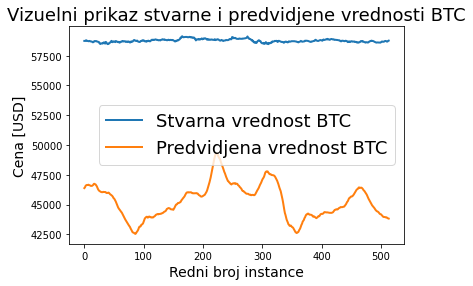

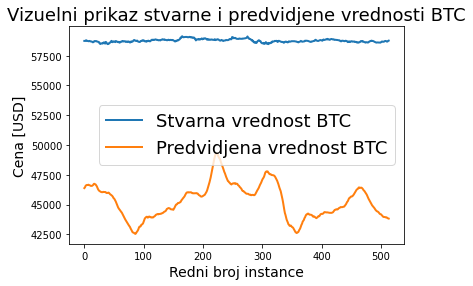

In [721]:
# Plotovanje stvarne i predvidjene vrednosti

# Bez validacije
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_no_validation)

# Sa validacijom
plot_real_vs_predicted_data(y_test, y_predicted_validation)

In [722]:
# Vizuelni prikaz gubitka i tacnosti tokom treniranja mreze

# Ukoliko je validacija nije koriscena tokom treniranja mreze,
# onda parametar is_validation_used treba biti 0, a inace 1

def plot_loss_and_mse(history_, is_validation_used):

  epochs = range(len(history_.history['loss'])) # broj epoha

  plt.title('Vizuelni prikaz gubitka (loss) i MSE (mse) mreze')


  # Gubitak

  plt.subplot(211)
  
  plt.plot(epochs, history_.history['loss'], label='Gubitak (loss) tokom treniranja')

  if is_validation_used == 1:
    plt.plot(epochs, history_.history['val_loss'], label='Gubitak (val_loss) tokom validacije')
  
  plt.legend()


  # Tacnost

  plt.subplot(212)

  plt.plot(epochs, history_.history['mse'], label='MSE tokom treniranja')
  
  if is_validation_used == 1:
    plt.plot(epochs, history_.history['val_mse'], label='MSE (val_mse) tokom validacije')
  
  plt.legend()

  plt.show()


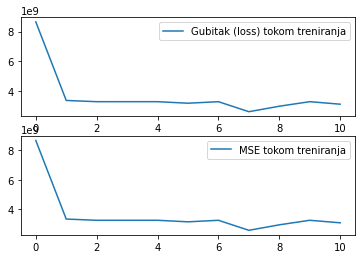

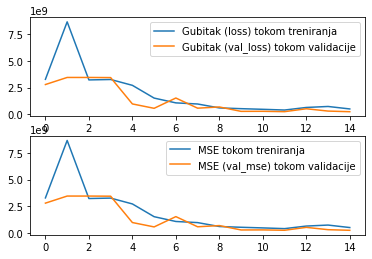

In [723]:
# Plotovanje gubitka i tacnosti mreze tokom treniranja

plot_loss_and_mse(history_ = history_no_validation, is_validation_used = 0)

plot_loss_and_mse(history_ = history_validation, is_validation_used = 1)

In [724]:
# Vizuelni prikaz MAE

def plot_mae(history_):

  epochs = range(len(history_.history['mae'])) # broj epoha
  plt.title('Vizuelni prikaz MAE (mae')
  plt.xlabel('broj epohe')
  plt.ylabel('MAE')
  
  plt.plot(epochs, history_.history['mae'], label='MAE (mae) tokom treniranja')

  if 'val_mae' in history_.history:
    plt.plot(epochs, history_.history['val_mae'], label='MAE (val_mae) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()


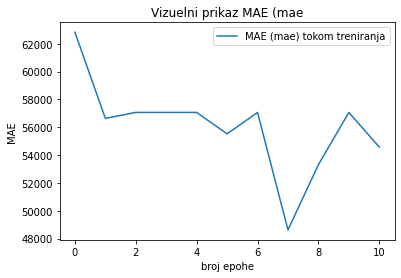

In [725]:
# MAE

plot_mae(history_no_validation)

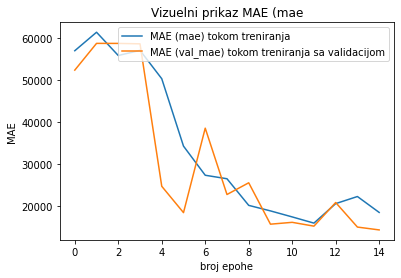

In [726]:
# MAE - sa validacijom

plot_mae(history_validation)

In [727]:
# Loss, MSE, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])

17/17 [==============================] - 1s 39ms/step - loss: 182966912.0000 - mse: 182966912.0000 - mae: 13449.7344

Metrike prilikom testiranja - model treniran bez validacije

loss 182966912.0
mse 182966912.0
mae 13449.734375


Metrike prilikom testiranja - model treniran sa validacijom

loss 182966912.0
mse 182966912.0
mae 13449.734375


In [728]:
# R2 skor nad skupom za testiranje
from sklearn import metrics

r2 = metrics.r2_score(y_predicted_no_validation, y_test)
r2_val = metrics.r2_score(y_predicted_validation, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije -86.4027463905458
R2 skor prilikom testiranja - model treniran sa validacijom -86.4027463905458
